# Problem 4

# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

We will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.


Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](ibm-granite/granite-timeseries-ttm-r1).

1. TTM-R1 pre-trained models can be found here: [TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024_96_v1"`
2. TTM-R2 pre-trained models can be found here: [TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024-96-r2"`
    3. For 1536-96 model set `TTM_MODEL_REVISION="1536-96-r2"`

Details about the revisions (R1 and R2) can be found [here](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

## 4.1 Environment Setup - Installation

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /tmp/pip-install-aqtz3s9d/tsfm-public_0a04e8b10fc44179b487f6070ff0fd04
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-aqtz3s9d/tsfm-public_0a04e8b10fc44179b487f6070ff0fd04
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 4.1 Environment Setup - Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

## 4.1 Environment Setup - Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here etth1) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Forecasting parameters
context_length = 1024
forecast_length = 96 # TTM-1024-96
fewshot_fraction = 0.05 # 5%

# ----- TTM model path -----
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"


# ----- TTM model branch -----
# For R2 models
TTM_MODEL_REVISION="1024-96-r2"

os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
print(f"DATA_ROOT_PATH : {DATA_ROOT_PATH}")
print(f"context/forecast: {context_length}/{forecast_length}")
print(f"model: {TTM_MODEL_PATH} @ {TTM_MODEL_REVISION}")

DATA_ROOT_PATH : https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
context/forecast: 1024/96
model: ibm-granite/granite-timeseries-ttm-r2 @ 1024-96-r2


## 4.2 Data processing pipeline

**Note:** Here we use the TimeSeriesPreprocessor (TSP) module for data preparation. For standard datasets, TSP can quickly prepare the dataloaders using YAML files defined [here](https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config). Refer to the [TTM Getting Started](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb) for example usage. Similar YAML file can be written for any new dataset as well.


In [6]:
# Load the data file and see the columns
data = pd.read_csv(DATA_ROOT_PATH, parse_dates=["date"])

print("Dataset shape:", data.shape)
print("\nColumns and data types:")
print(data.dtypes)
print("\nFirst 20 rows:")
display(data.head(20))

print("\nSummary statistics:")
display(data.describe())

print("\nMissing values per column:")
print(data.isna().sum())

Dataset shape: (17420, 8)

Columns and data types:
date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object

First 20 rows:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
6,2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
7,2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
8,2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000
9,2016-07-01 09:00:00,4.555,2.545,1.919,0.817,2.680,1.371,17.445999



Summary statistics:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,2017-06-28 21:30:00,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
min,2016-07-01 00:00:00,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,2016-12-29 10:45:00,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,2017-06-28 21:30:00,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,2017-12-27 08:15:00,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,2018-06-26 19:00:00,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000
std,NaN,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946



Missing values per column:
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


In [7]:
# Display first 20 rows again
timestamp_column = "date"
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

print("Columns:", list(data.columns))
display(data.head(20))

Columns: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
6,2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
7,2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
8,2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000
9,2016-07-01 09:00:00,4.555,2.545,1.919,0.817,2.680,1.371,17.445999


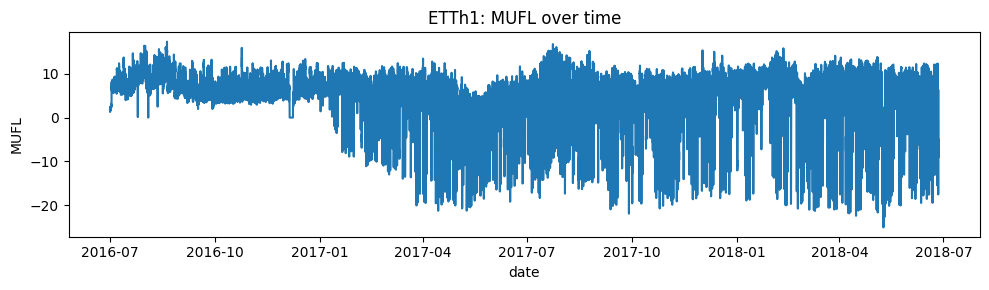

In [8]:
  # Plot date vs ”MUFL”
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(data[timestamp_column], data["MUFL"])
plt.xlabel("date")
plt.ylabel("MUFL")
plt.title("ETTh1: MUFL over time")
plt.tight_layout()
plt.show()

In [10]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24],
    "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
    "test": [
        12 * 30 * 24 + 4 * 30 * 24,
        12 * 30 * 24 + 8 * 30 * 24,
    ],
}

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Obtain the train_dataset, valid_dataset, test_dataset using tsp get_dataset() by specifying the right arguments
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_config,)

# Print the length of train_dataset, valid_dataset, test_dataset
print("train len:", len(train_dataset))
print("valid len:", len(valid_dataset))
print("test  len:", len(test_dataset))

train len: 7521
valid len: 2785
test  len: 2785


In [11]:
train_dataset[3]

{'past_values': tensor([[-0.4899, -0.0378, -0.6887,  ...,  1.0017,  0.7784,  0.8626],
         [-0.4438, -0.0378, -0.6501,  ...,  1.0613,  0.7784,  0.5252],
         [-0.3977,  0.0584, -0.6436,  ...,  1.2401,  0.9243,  0.4409],
         ...,
         [ 0.8122,  1.3726,  0.6442,  ...,  1.2108,  0.9243,  1.9895],
         [ 0.8468,  1.4683,  0.6056,  ...,  1.3886,  1.0211,  1.8822],
         [ 0.6509,  1.4683,  0.4317,  ...,  1.3886,  1.1163,  1.8132]]),
 'future_values': tensor([[0.7661, 1.3726, 0.5411, 1.1990, 1.5078, 0.7784, 1.6139],
         [1.7342, 0.9880, 1.1914, 0.5351, 3.5312, 0.9719, 1.5755],
         [1.6996, 0.7315, 1.1079, 0.0554, 3.4130, 1.0687, 1.5525],
         [2.3218, 2.3659, 1.9126, 1.9185, 2.7877, 0.8275, 1.5678],
         [2.0567, 1.8209, 1.7388, 1.2914, 2.2220, 0.8275, 1.5372],
         [2.2412, 1.8851, 1.7388, 1.2359, 3.7100, 1.4067, 1.5678],
         [2.2066, 2.1736, 1.6551, 1.1990, 3.5019, 1.3591, 1.4835],
         [1.7687, 1.2765, 1.3139, 0.7562, 3.0261, 1.2131,

## 4.3 Zero-shot evaluation method

In [12]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
zeroshot_model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

In [13]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

In [22]:
#Perform zero-shot evaluation using the pre-trained model on the test dataset and calculate the evaluation error.
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. model predeiction
pred_out = zeroshot_trainer.predict(test_dataset)
preds = pred_out.predictions
y_pred = preds[0] if isinstance(preds, (tuple, list)) else preds
# torch.Tensor -> numpy
if hasattr(y_pred, "detach"):
    y_pred = y_pred.detach().cpu().numpy()
y_pred = np.asarray(y_pred)   # [N, H, C]
print(y_pred.shape)

(2785, 96, 7)


In [24]:
# 2) label
ys = []
masks = []
for i in range(len(test_dataset)):
    s = test_dataset[i]
    if isinstance(s, dict):
        if "future_values" in s:
            t = s["future_values"]
            mask = s.get("future_observed_mask", None)
        elif "labels" in s:
            t = s["labels"]
            mask = None
        else:
            raise KeyError(f"No label-like key in sample: {list(s.keys())}")
    elif isinstance(s, (tuple, list)) and len(s) >= 2:
        t = s[1]
        mask = None
    else:
        raise KeyError(f"Unsupported sample type: {type(s)}")

    if hasattr(t, "detach"): # torch.Tensor -> numpy
        t = t.detach().cpu().numpy()
    ys.append(np.asarray(t))

    if mask is not None:
        if hasattr(mask, "detach"):
            mask = mask.detach().cpu().numpy()
        masks.append(np.asarray(mask))

y_true = np.stack(ys, axis=0)  # [N, H, C]
print("y_true shape:", y_true.shape)


y_true shape: (2785, 96, 7)


In [25]:
# 3) Horizon length
if y_true.shape[1] != y_pred.shape[1]:
    y_true = y_true[:, : y_pred.shape[1], :]

# 4) metrics
y_pred_flat = y_pred.ravel().astype(np.float32)
y_true_flat = y_true.ravel().astype(np.float32)
mae  = mean_absolute_error(y_true_flat, y_pred_flat)
mse  = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
print(f"[Zero-shot @ test] MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

[Zero-shot @ test] MAE: 0.3942 | MSE: 0.3586 | RMSE: 0.5988


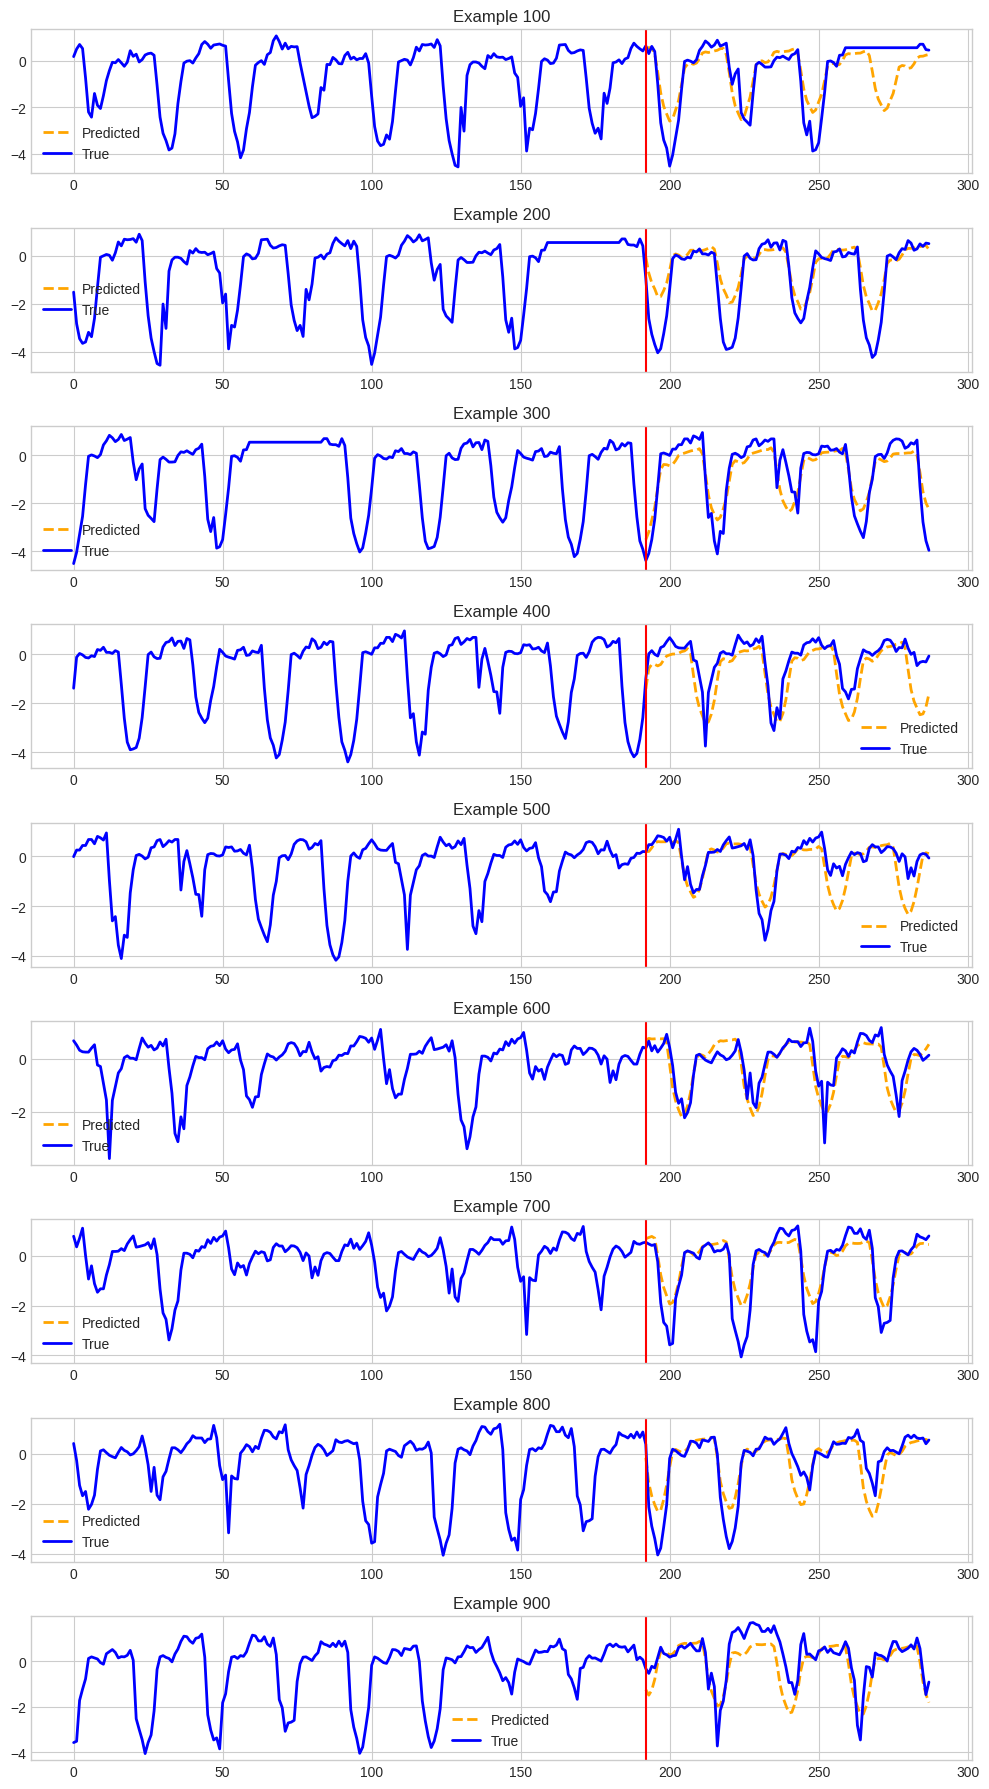

In [27]:
# plot the zero-shot predictions
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="zeroshot_eval",
    indices=[100, 200, 300, 400, 500, 600, 700, 800, 900],
    channel=0,
)


## 4.4 Zero-shot evaluation by truncating the length

In [33]:
#Forecast 24 hrs in the future using the TTM-1024-96 model

# dataset (prediction_length = 24)
tsp_24 = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=24,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

_, _, test_dataset_24 = get_datasets(
    tsp_24,
    data,
    split_config,
)

# 1) Load the same pre-trained TTM, but restrict outputs to 24 steps
trunc_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,# "1024-96-r2"
    prediction_filter_length=24, # only predict first 24 horizons
)

# 2) Trainer for evaluation
temp_dir = tempfile.mkdtemp()
trunc_trainer = Trainer(
    model=trunc_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        dataloader_drop_last=False,
        seed=SEED,
        logging_steps=50,
    ),
)

def _np(x):
    if isinstance(x, (tuple, list)):
        x = x[0] if len(x) > 0 else None
    if x is None:
        return None
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

# 3) Predict on the same test set
trunc_output = trunc_trainer.predict(test_dataset_24)

y_pred_24 = _np(trunc_output.predictions) # [N, 24, C]
print("y_pred_24 shape:", y_pred_24.shape)

y_true_all = _np(trunc_output.label_ids)
if y_true_all is None:
    ys, masks = [], []
    for i in range(len(test_dataset_24)):
        s = test_dataset_24[i]
        if isinstance(s, dict) and "future_values" in s:
            t = s["future_values"]
            m = s.get("future_observed_mask", None)
        elif isinstance(s, (tuple, list)) and len(s) >= 2:
            t = s[1]; m = None
        else:
            raise KeyError(f"No label-like key in sample: {list(s.keys()) if isinstance(s, dict) else type(s)}")

        if hasattr(t, "detach"):
            t = t.detach().cpu().numpy()
        ys.append(np.asarray(t))

        if m is not None:
            if hasattr(m, "detach"):
                m = m.detach().cpu().numpy()
            masks.append(np.asarray(m))

    y_true_all = np.stack(ys, axis=0)            # [N, H(=96), C]
    mask_all = np.stack(masks, axis=0) if masks else None
else:
    mask_all = None
print("y_true_all shape:", y_true_all.shape)

y_true_24 = y_true_all[:, :y_pred_24.shape[1], :]   # match 24 steps
print("y_true_24 shape:", y_true_24.shape)

yp_flat = y_pred_24.reshape(-1).astype(np.float32)
yt_flat = y_true_24.reshape(-1).astype(np.float32)

mse  = mean_squared_error(yt_flat, yp_flat)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(yt_flat, yp_flat)
print(f"[Zero-shot (24-step)]  MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

y_pred_24 shape: (2857, 24, 7)
y_true_all shape: (2857, 24, 7)
y_true_24 shape: (2857, 24, 7)
[Zero-shot (24-step)]  MAE: 0.3630 | MSE: 0.3101 | RMSE: 0.5569


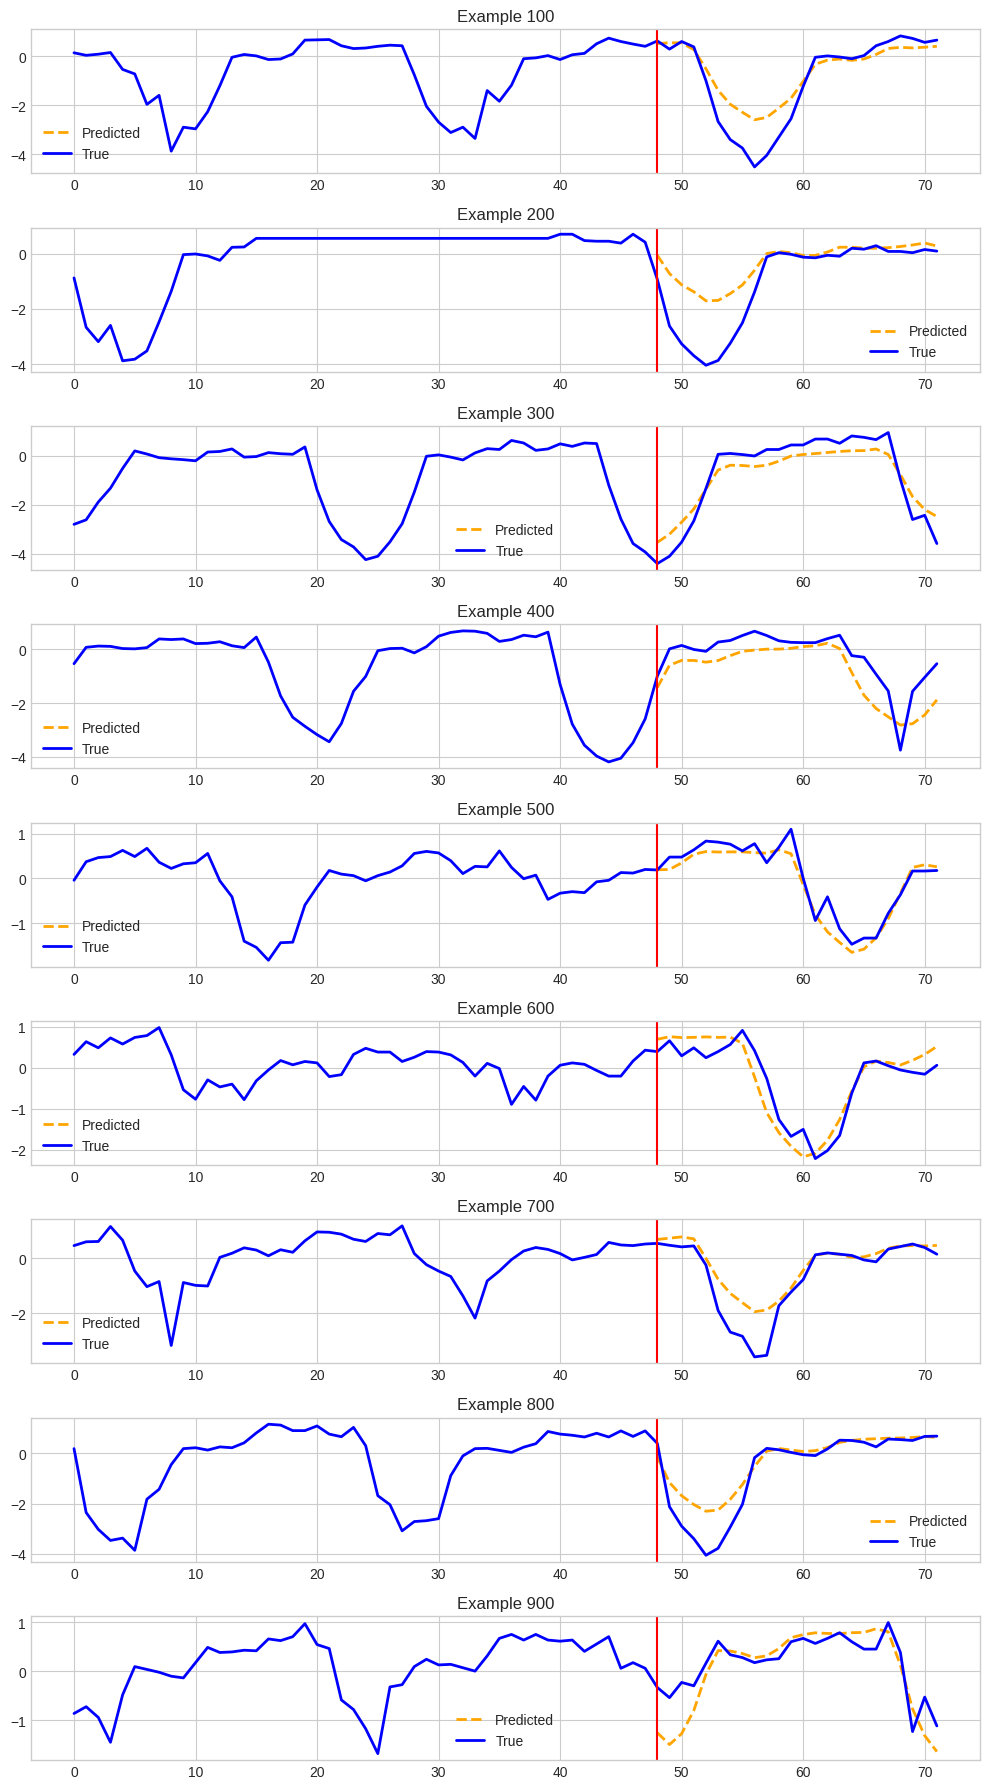

In [34]:
# 4) Plot a sample with 24-step truncation
plot_predictions(
    model=trunc_trainer.model,
    dset=test_dataset_24,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="zeroshot_24step",
    indices=[100, 200, 300, 400, 500, 600, 700, 800, 900],
    channel=0,
)

**Analysis of Zero-shot (full vs. truncates)**

The zero-shot 96-step forecast already achieves a MAE of 0.394 and RMSE of 0.599, indicating strong generalization from pre-training.
When truncating the forecast horizon to 24 steps, the model’s error decreases (MAE decreases to 0.363, RMSE decreases to 0.557), confirming that shorter prediction horizons are easier and yield more accurate short-term forecasts due to reduced temporal uncertainty and error propagation over time.

 ## 4.5 Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [35]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

### Freeze the TTM backbone

In [36]:
import os, math, tempfile, numpy as np, torch
from torch.utils.data import Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from tsfm_public import (
    TinyTimeMixerForPrediction, TrackingCallback, count_parameters
)
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

In [37]:
def make_subset(dataset, frac, seed=42):
    n = len(dataset)
    k = max(1, int(round(n * frac)))
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(n, generator=g)[:k].tolist()
    return Subset(dataset, idx), k, n

In [38]:
def _np(x):
    if isinstance(x, (tuple, list)):
        x = x[0] if len(x) > 0 else None
    if x is None:
        return None
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _metrics_all_channels(y_true, y_pred):
    # y_*: [N, H, C]
    y_true = y_true[:, :y_pred.shape[1], :]
    yt = y_true.ravel().astype(np.float32)
    yp = y_pred.ravel().astype(np.float32)
    mse  = mean_squared_error(yt, yp)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(yt, yp)
    return {"mae": float(mae), "mse": float(mse), "rmse": rmse}

In [39]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for name, p in finetune_forecast_model.named_parameters():
    p.requires_grad = ("head" in name)

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 2964960
Number of params after freezing the backbone 196704


### Finetune few-shot 5%

In [40]:
# Important parameters
learning_rate = 0.001
num_epochs = 1  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [41]:
train_subset, k_sub, n_all = make_subset(train_dataset, frac=0.05, seed=SEED)
print(f"Train few-shot subset: {k_sub}/{n_all} examples (~5%)")

Train few-shot subset: 376/7521 examples (~5%)


In [42]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output_fewshot_5"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to= "none",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.701500,0.674564


[TrackingCallback] Mean Epoch Time = 5.197975158691406 seconds, Total Train Time = 7.3551344871521


TrainOutput(global_step=118, training_loss=0.7014766628459349, metrics={'train_runtime': 7.3552, 'train_samples_per_second': 1022.546, 'train_steps_per_second': 16.043, 'total_flos': 959055354593280.0, 'train_loss': 0.7014766628459349, 'epoch': 1.0})

In [44]:
# Evaluate the fine-tuned model
pred_out = finetune_forecast_trainer.predict(test_dataset)
y_pred = _np(pred_out.predictions) # [N,H,C]
print("y_pred shape:", y_pred.shape)
y_true = _np(pred_out.label_ids)
if y_true is None:
    ys = []
    for i in range(len(test_dataset)):
        s = test_dataset[i]
        if isinstance(s, dict) and "future_values" in s:
            t = s["future_values"]
        elif isinstance(s, (tuple, list)) and len(s) >= 2:
            t = s[1]
        else:
            raise KeyError("No label in sample")
        if hasattr(t, "detach"):
            t = t.detach().cpu().numpy()
        ys.append(np.asarray(t))
    y_true = np.stack(ys, axis=0)
print("y_true shape:", y_true.shape)

m = _metrics_all_channels(y_true, y_pred)
print(f"[Few-shot 5% @ test]  MAE={m['mae']:.4f} | MSE={m['mse']:.4f} | RMSE={m['rmse']:.4f}")

y_pred shape: (2785, 96, 7)
y_true shape: (2785, 96, 7)
[Few-shot 5% @ test]  MAE=0.3944 | MSE=0.3594 | RMSE=0.5995


### Finetune few-shot 10%

In [46]:
# 1) model reload
finetune_forecast_model_10 = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)

print("Params before freezing (10%):", count_parameters(finetune_forecast_model_10))

# 2) backbone freeze
for name, p in finetune_forecast_model_10.named_parameters():
    p.requires_grad = ("head" in name)

print("Params after  freezing (10%):", count_parameters(finetune_forecast_model_10))

# 3) 10% few-shot sutset
train_subset_10, k_sub_10, n_all_10 = make_subset(train_dataset, frac=0.10, seed=SEED)
print(f"Train few-shot subset (10%): {k_sub_10}/{n_all_10}")

Params before freezing (10%): 2964960
Params after  freezing (10%): 196704
Train few-shot subset (10%): 752/7521


In [47]:
# 4) Trainer setting (1 epoch)
learning_rate = 1e-3
num_epochs = 1
batch_size = 64

finetune_args_10 = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output_fewshot_10"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=2,
    report_to= "none",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

early_stopping_10 = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.0,
)
tracking_cb_10 = TrackingCallback()

optimizer_10 = AdamW(finetune_forecast_model_10.parameters(), lr=learning_rate)
steps_per_epoch_10 = max(1, math.ceil(len(train_subset_10) / batch_size))
scheduler_10 = OneCycleLR(optimizer_10, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch_10)

trainer_10 = Trainer(
    model=finetune_forecast_model_10,
    args=finetune_args_10,
    train_dataset=train_subset_10,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_10, tracking_cb_10],
    optimizers=(optimizer_10, scheduler_10),
)

# 5) train
trainer_10.train()

Epoch,Training Loss,Validation Loss
1,1.006800,0.672920


[TrackingCallback] Mean Epoch Time = 1.0418550968170166 seconds, Total Train Time = 3.7401208877563477


TrainOutput(global_step=12, training_loss=1.0067661603291829, metrics={'train_runtime': 3.7407, 'train_samples_per_second': 201.034, 'train_steps_per_second': 3.208, 'total_flos': 95892783759360.0, 'train_loss': 1.0067661603291829, 'epoch': 1.0})

In [48]:
# 6) Test evaluation
pred_out_10 = trainer_10.predict(test_dataset)
y_pred_10 = _np(pred_out_10.predictions)  # [N,H,C]
print("y_pred_10 shape:", y_pred_10.shape)
y_true_10 = _np(pred_out_10.label_ids)

if y_true_10 is None:
    ys = []
    for i in range(len(test_dataset)):
        s = test_dataset[i]
        if isinstance(s, dict) and "future_values" in s:
            t = s["future_values"]
        elif isinstance(s, (tuple, list)) and len(s) >= 2:
            t = s[1]
        else:
            raise KeyError("No label in sample")
        if hasattr(t, "detach"):
            t = t.detach().cpu().numpy()
        ys.append(np.asarray(t))
    y_true_10 = np.stack(ys, axis=0)
print("y_true_10 shape:", y_true_10.shape)

metrics_10 = _metrics_all_channels(y_true_10, y_pred_10)
print(f"[Few-shot 10% @ test]  MAE={metrics_10['mae']:.4f} | MSE={metrics_10['mse']:.4f} | RMSE={metrics_10['rmse']:.4f}")

y_pred_10 shape: (2785, 96, 7)
y_true_10 shape: (2785, 96, 7)
[Few-shot 10% @ test]  MAE=0.3957 | MSE=0.3607 | RMSE=0.6006


**Analysis of Few-shot (5% vs. 10%)**

When fine-tuning the pre-trained TTM-1024-96 model on ETTh1 using 5% and 10% of the training data, both settings yielded nearly identical results (MAE = 0.39, RMSE = 0.60).
This indicates that the backbone freezing limits the benefit of increasing data volume, since only the prediction head was trainable. Moreover, with only one training epoch, the 10% subset did not provide additional performance gains.
Therefore, the model’s zero-shot generalization dominates the few-shot improvements under the frozen-backbone configuration.

## 4.6 Few-shot evaluation by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

In [49]:
model_mae = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    head_dropout=0.7,
)

# loss = MAE
if hasattr(model_mae, "loss"):
    model_mae.loss = "mae"
if hasattr(model_mae, "config"):
    try:
        model_mae.config.loss = "mae"
    except Exception:
        pass

print("Params before freezing:", count_parameters(model_mae))

for name, p in model_mae.named_parameters():
    p.requires_grad = ("head" in name)

print("Params after  freezing:", count_parameters(model_mae))

train_subset_5, k_sub_5, n_all_5 = make_subset(train_dataset, frac=0.05, seed=SEED)
print(f"Train few-shot subset (5%): {k_sub_5}/{n_all_5}")

Params before freezing: 2964960
Params after  freezing: 196704
Train few-shot subset (5%): 376/7521


In [50]:
learning_rate = 1e-3
num_epochs = 1
batch_size = 64

args_5_mae = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output_fewshot_5_mae"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=2,
    report_to= "none",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.0,
)
tracking_cb = TrackingCallback()

optimizer = AdamW(model_mae.parameters(), lr=learning_rate)
steps_per_epoch = max(1, math.ceil(len(train_subset_5) / batch_size))
scheduler = OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

trainer_5_mae = Trainer(
    model=model_mae,
    args=args_5_mae,
    train_dataset=train_subset_5,
    eval_dataset=valid_dataset,
    callbacks=[early_stop, tracking_cb],
    optimizers=(optimizer, scheduler),
)

trainer_5_mae.train()

Epoch,Training Loss,Validation Loss
1,0.631400,0.557661


[TrackingCallback] Mean Epoch Time = 0.7443454265594482 seconds, Total Train Time = 2.9058032035827637


TrainOutput(global_step=6, training_loss=0.6314095656077067, metrics={'train_runtime': 2.9063, 'train_samples_per_second': 129.373, 'train_steps_per_second': 2.064, 'total_flos': 47946391879680.0, 'train_loss': 0.6314095656077067, 'epoch': 1.0})

In [51]:
pred_out_5_mae = trainer_5_mae.predict(test_dataset)

y_pred_5_mae = _np(pred_out_5_mae.predictions)   # [N, H, C]
y_true_5_mae = _np(pred_out_5_mae.label_ids)
if y_true_5_mae is None:
    ys = []
    for i in range(len(test_dataset)):
        s = test_dataset[i]
        if isinstance(s, dict) and "future_values" in s:
            t = s["future_values"]
        elif isinstance(s, (tuple, list)) and len(s) >= 2:
            t = s[1]
        else:
            raise KeyError("No label in sample")
        if hasattr(t, "detach"):
            t = t.detach().cpu().numpy()
        ys.append(np.asarray(t))
    y_true_5_mae = np.stack(ys, axis=0)

metrics_5_mae = _metrics_all_channels(y_true_5_mae, y_pred_5_mae)
print(f"[Few-shot 5% (loss=MAE) @ test]  "
      f"MAE={metrics_5_mae['mae']:.4f} | MSE={metrics_5_mae['mse']:.4f} | RMSE={metrics_5_mae['rmse']:.4f}")

[Few-shot 5% (loss=MAE) @ test]  MAE=0.3953 | MSE=0.3596 | RMSE=0.5997


**Analysis of 5% few-shot (MSE vs MAE)**

In the 5% few-shot fine-tuning experiment on ETTh1, both MSE and MAE losses produced nearly identical results:
- MSE loss: MAE = 0.3944 | MSE = 0.3594 | RMSE = 0.5995
- MAE loss: MAE = 0.3953 | MSE = 0.3596 | RMSE = 0.5997

The negligible difference shows that changing the loss function alone has little impact when the backbone is frozen and only the prediction head is updated for one epoch. Since ETTh1 is relatively smooth and noise-free, the robustness advantage of MAE does not appear. Overall, both losses yield comparable generalization, indicating that loss choice is less influential than data size or training depth in such limited few-shot settings.


## 4.7 Zero-shot on channel 0 and 2
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```

In [52]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    prediction_channel_indices=[0,2])

sample = test_dataset[0]

past_values = sample["past_values"].unsqueeze(0)
print("past value shape:", past_values.shape)

past value shape: torch.Size([1, 1024, 7])


In [53]:
with torch.no_grad():
    output = zeroshot_model.forward(past_values, return_loss=False)

print("Prediction output shape:", output.prediction_outputs.shape)

Prediction output shape: torch.Size([1, 96, 2])


Since prediction_channel_indices=[0,2], the model head only predicts two channels. Thus, the output tensor shape becomes [batch, forecast_length, len(prediction_channel_indices)] = [1, 96, 2].